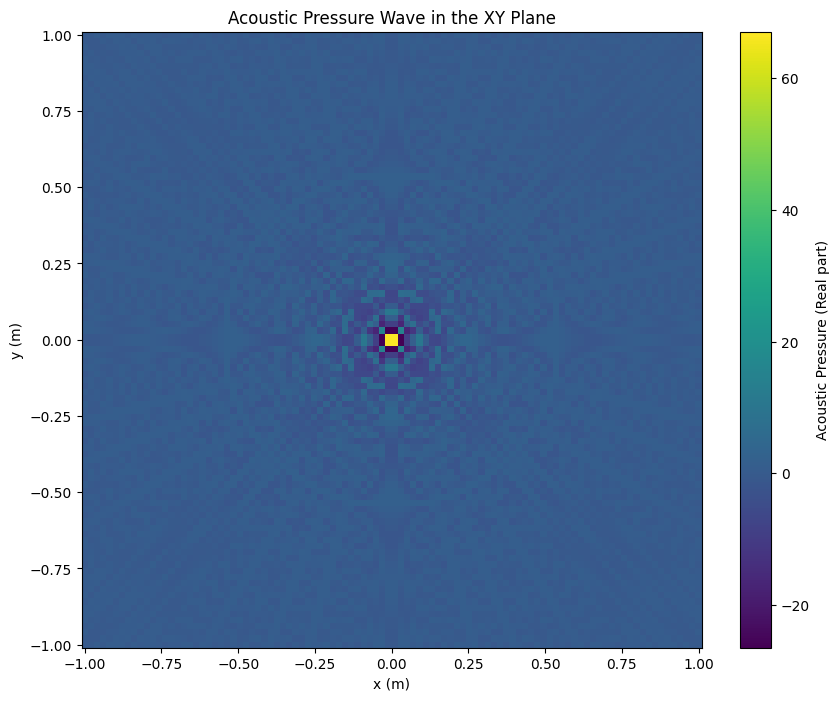

In [7]:
# Angular Spectrum Method

import numpy as np
import matplotlib.pyplot as plt

# Constants
speed_of_sound = 343  # Speed of sound in air in m/s
frequency = 1000  # Frequency of the acoustic wave in Hz
wavelength_m = speed_of_sound / frequency  # Wavelength of the acoustic wave in m
k_m = 2 * np.pi / wavelength_m  # Wavenumber

# Function A(x,y,z) that defines the amplitude of the acoustic wave
def A(x, y, z):
    # For simplicity, let's assume a spherical wave originating from the origin
    r = np.sqrt(x**2 + y**2 + z**2)
    return 1 / r  # Amplitude decreases with distance as 1/r

# Function f(x,y,z) that defines the phase of the acoustic wave
def f(x, y, z):
    r = np.sqrt(x**2 + y**2 + z**2)
    return k_m * r  # Phase is proportional to the distance from the origin

# Spatial grid
x = np.linspace(-1, 1, 100)  # 100 points from -1 to 1 meters
y = np.linspace(-1, 1, 100)  # 100 points from -1 to 1 meters
z = 0  # We will model the wave in the XY plane at z=0 for simplicity

# Calculate the pressure wave
X, Y = np.meshgrid(x, y)  # Create a grid of x and y values
P = A(X, Y, z) * np.exp(1j * f(X, Y, z))  # Calculate the pressure wave

# Plot the real part of the pressure wave
plt.figure(figsize=(10, 8))
plt.pcolormesh(X, Y, P.real, shading='auto')
plt.colorbar(label='Acoustic Pressure (Real part)')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Acoustic Pressure Wave in the XY Plane')
plt.show()


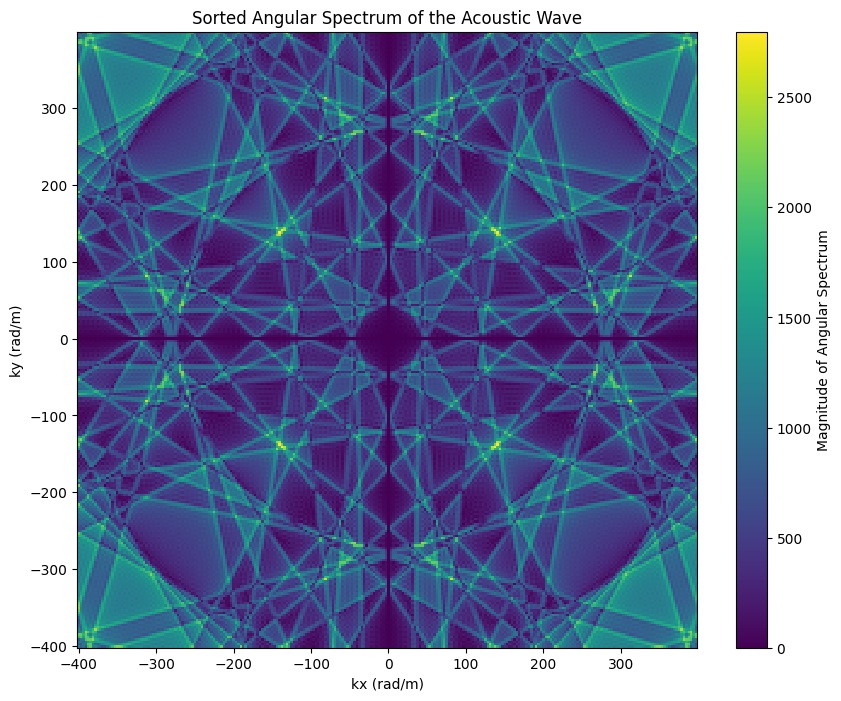

In [8]:
from scipy.fft import fft2, fftshift

# Define the spatial domain
x = np.linspace(-1, 1, 256)  # Spatial domain from -1 to 1 meters
y = np.linspace(-1, 1, 256)  # Spatial domain from -1 to 1 meters
z = 0  # We will model the wave in the XY plane at z=0 for simplicity

# Create a grid of x and y values
X, Y = np.meshgrid(x, y)

# Calculate the pressure wave at the XY plane
P = A(X, Y, z) * np.exp(1j * f(X, Y, z))

# Perform the Fourier transform to obtain the angular spectrum
P_k = fft2(P)
P_k_shifted = fftshift(P_k)  # Shift the zero frequency component to the center of the spectrum

# Define the wavenumber domain
kx = 2 * np.pi * np.fft.fftfreq(P.shape[0], d=(x[1] - x[0]))
ky = 2 * np.pi * np.fft.fftfreq(P.shape[1], d=(y[1] - y[0]))
KX, KY = np.meshgrid(kx, ky)

# Sort the kx and ky arrays in ascending order and apply the same sorting to the Fourier-transformed data
kx_sorted_indices = np.argsort(kx)
ky_sorted_indices = np.argsort(ky)

KX_sorted, KY_sorted = np.meshgrid(kx[kx_sorted_indices], ky[ky_sorted_indices])
P_k_shifted_sorted = P_k_shifted[np.ix_(ky_sorted_indices, kx_sorted_indices)]

# Plot the magnitude of the sorted angular spectrum
plt.figure(figsize=(10, 8))
plt.pcolormesh(KX_sorted, KY_sorted, np.abs(P_k_shifted_sorted), shading='auto')
plt.colorbar(label='Magnitude of Angular Spectrum')
plt.xlabel('kx (rad/m)')
plt.ylabel('ky (rad/m)')
plt.title('Sorted Angular Spectrum of the Acoustic Wave')
plt.show()


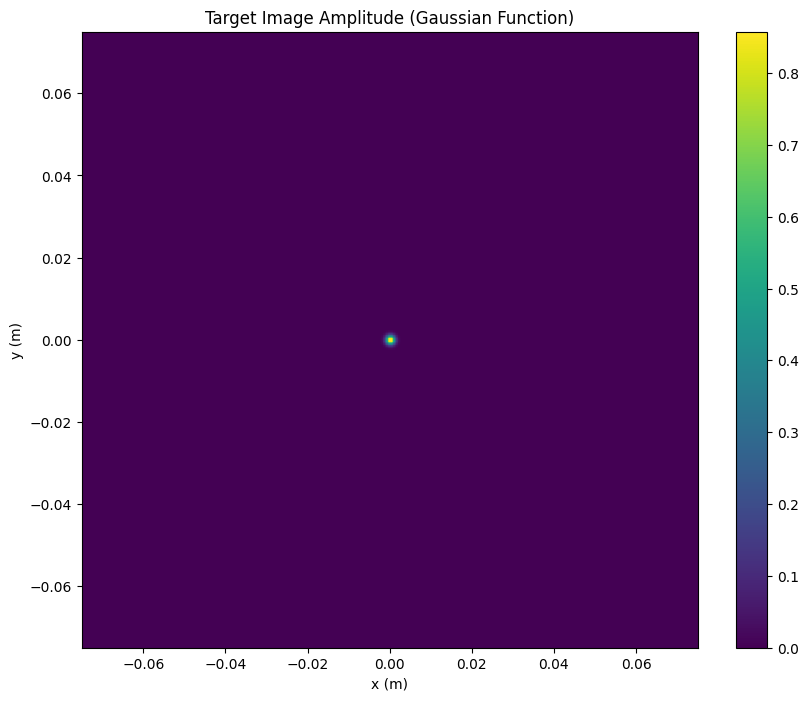

Iteration 0: MSE = 0.9997662176990997
Iteration 1: MSE = 0.9169929513185557
Iteration 2: MSE = 0.9163402775150252
Iteration 3: MSE = 0.9162689994142753
Iteration 4: MSE = 0.9161857904239596
Iteration 5: MSE = 0.9161066180272497
Iteration 6: MSE = 0.9160392920674653
Iteration 7: MSE = 0.9159858619178699
Iteration 8: MSE = 0.9159453226263722
Iteration 9: MSE = 0.9159154704538687
Iteration 10: MSE = 0.9158939266512716
Iteration 11: MSE = 0.9158785902018229
Iteration 12: MSE = 0.9158677741204981
Iteration 13: MSE = 0.9158601947105522
Iteration 14: MSE = 0.9158549067081351
Iteration 15: MSE = 0.9158512285177421
Iteration 16: MSE = 0.9158486753949046
Iteration 17: MSE = 0.9158469057540437
Iteration 18: MSE = 0.9158456803819844
Iteration 19: MSE = 0.9158448324644994


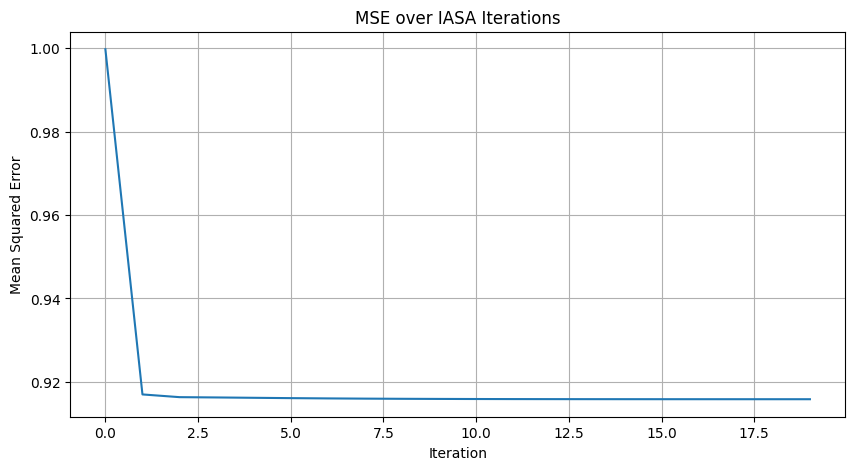

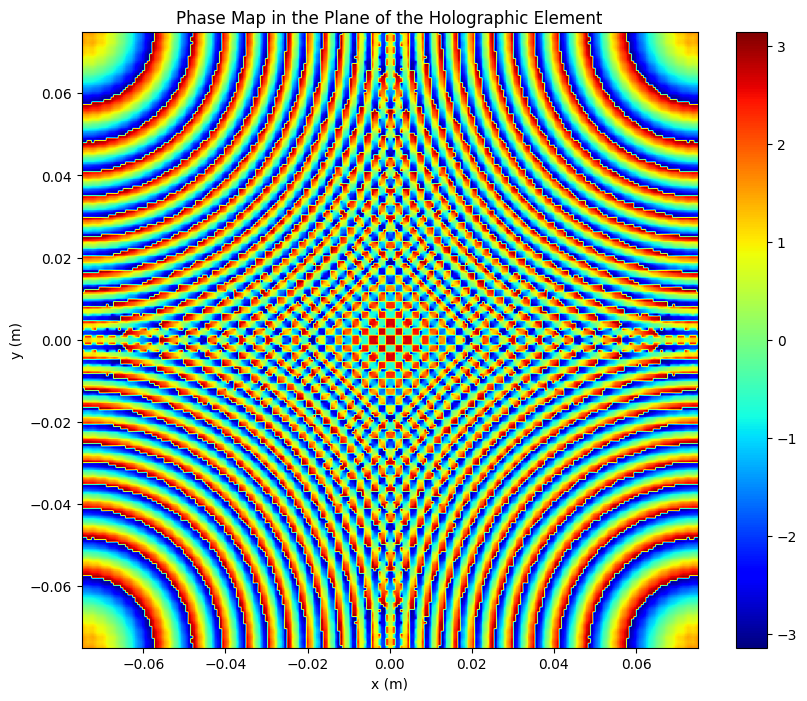

In [11]:
"""
The code provided models the iterative angular spectrum approach (IASA) to compute the phase map of an acoustic hologram. 
It sets up a computational domain based on the parameters given in the document, uses a placeholder Gaussian function to 
represent the amplitude in the image plane, and iterates through the propagation process to optimize the phase distribution
on the hologram.
After running for a predefined number of iterations, it outputs the phase map in the plane of the holographic element, 
which would then be used to fabricate the physical hologram for acoustic manipulation experiments. The actual target image
amplitude and phase function maps would be determined by the specific application requirements as detailed in the document.
"""

import numpy as np
from scipy.fft import fft2, fftshift, ifft2
import matplotlib.pyplot as plt

# Constants for the example in the document
speed_of_sound = 1500  # Speed of sound in water, 1500 m/s; in air, 343 m/s
frequency = 2e6  # Frequency in water, 2 MHz, in air, 100 kHz 
wavelength_m = speed_of_sound / frequency  # Wavelength in water, 750e-6 (750 micrometers); in air, 3.34 mm
k_m = 2 * np.pi / wavelength_m  # Wavenumber

speed_of_sound_h = 2424 # Speed of sound in the hologram in m/s
sound_attenuation_h = 550 # Sound attenuation in the hologram in dB/m
wavelength_h = speed_of_sound_h / sound_attenuation_h # CHECK?
k_h = 2 * np.pi / wavelength_h  # Wavenumber in hologram

Lh = Li = 0.05  # Side lengths of the hologram and image planes in meters
delta_z = 0.0257  # Distance between the hologram plane (z=0) and the image plane, 25.7 mm in air experiment

# Computational domain size (extended to avoid aliasing)
Ld = 3 * max(Lh, Li)

# Number of pixels in each dimension (assuming square pixels)
N = 256
d = Lh / N  # Pixel size

# Define spatial axes
x = np.linspace(-Ld / 2, Ld / 2, N)
y = np.linspace(-Ld / 2, Ld / 2, N)
X, Y = np.meshgrid(x, y)

# Define transducer output pressure distribution (assuming uniform for simplicity)
transducer_pressure = np.ones_like(X)

# Initialize phase distribution of the hologram to zero
hologram_phase = np.zeros_like(X)

# Initialize amplitude and phase function maps (assuming example target distributions)
image_phase = np.zeros_like(X)  # Placeholder for the actual phase function map

# For simplicity, using a Gaussian as a placeholder for the actual target image amplitude

# Define the Gaussian function as the target image amplitude
def gaussian_amplitude(X, Y, wavelength):
    return np.exp(-((X**2 + Y**2) / (2 * (wavelength)**2)))

# Calculate the target image amplitude
image_amplitude = gaussian_amplitude(X, Y, wavelength_m)

# Visualize the input function - the placeholder Gaussian function for the target image amplitude
plt.figure(figsize=(10, 8))
plt.imshow(image_amplitude, cmap='viridis', extent=(x.min(), x.max(), y.min(), y.max()))
plt.colorbar()
plt.title('Target Image Amplitude (Gaussian Function)')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()


# Propagation function using the Angular Spectrum Method
def propagate(angular_spectrum, z, k_limit):
    kx = 2 * np.pi * np.fft.fftfreq(N, d=d)
    ky = 2 * np.pi * np.fft.fftfreq(N, d=d)
    KX, KY = np.meshgrid(kx, ky)
    
    # Define a mask for the spatial frequencies within the allowed limit
    mask = (KX**2 + KY**2) <= k_limit**2

    KZ = np.sqrt(k_m**2 - KX**2 - KY**2, where=mask)
    KZ = np.nan_to_num(KZ)  # Replace NaNs with zero for non-propagating components
    propagator = np.exp(1j * KZ * z)
    
    # Apply the mask to the angular spectrum
    angular_spectrum_limited = angular_spectrum * mask

    propagated_field = fftshift(ifft2(angular_spectrum_limited * propagator))
    return propagated_field

# Maximum spatial frequency that can be resolved by the system
Lh = 0.050  # Side length of the hologram, 50 mm?
Li = 0.050  # Side length of the image plane, 50 mm?
lambda_ = wavelength_m  # Wavelength in the medium
delta_z = 0.030  # Distance between the hologram and image plane

# Calculate k_limit based on the provided equation
k_limit = (np.pi * (Lh + Li)) / (lambda_ * np.sqrt((1/4) * (Lh + Li)**2 + delta_z**2))

# Define a function to calculate the mean squared error (MSE)
def mean_squared_error(target, reconstructed):
    return np.mean((target - reconstructed)**2)

# Constants for the material properties (replace with actual values from the paper or your experiment)
Z_t = 1e6  # Acoustic impedance of the transducer face
Z_h = 2.58e6  # Acoustic impedance of the hologram https://www.omnicalculator.com/physics/acoustic-impedance 
Z_m = 1.4e6  # Acoustic impedance of the medium (water) https://radiopaedia.org/articles/acoustic-impedance?lang=us 

# Equation 8 for the thickness change delta_T(x,y)
# We will need to define a starting thickness T0 for the hologram
T0 = 0.01  # Starting thickness of the hologram, 1 cm?

# Equation 7 for the transmission coefficient alpha_T(x,y)
def transmission_coefficient(Z_t, Z_h, Z_m, k_h, T):
    numerator = 4 * Z_t * Z_h**2 * Z_m
    denominator = (Z_h**2 * (Z_t + Z_m)**2 * np.cos(k_h * T)**2 +
                   (Z_h**2 + Z_t * Z_m)**2 * np.sin(k_h * T)**2)
    alpha_T = numerator / denominator
    return alpha_T

# Iterative Angular Spectrum Approach (IASA)
max_iterations = 20  # Maximum number of iterations for simplicity
mse_history = []  # To store the MSE after each iteration
for iteration in range(max_iterations):
    # Propagate from hologram to image plane
    angular_spectrum_holo = fft2(transducer_pressure * np.exp(1j * hologram_phase))
    field_image_plane = propagate(angular_spectrum_holo, delta_z, k_limit)

    # Calculate the mean squared error between the target and the reconstructed image
    mse = mean_squared_error(image_amplitude, np.abs(field_image_plane))
    mse_history.append(mse)
    
    print(f'Iteration {iteration}: MSE = {mse}')

    # Reset the amplitude in the image plane to match the target value
    # Retain the forward-propagated phase
    field_image_plane = image_amplitude * np.exp(1j * np.angle(field_image_plane))

    # Propagate from image plane back to hologram
    angular_spectrum_image = fft2(field_image_plane)
    field_hologram_plane = propagate(angular_spectrum_image, -delta_z, k_limit)

    # Sum the back-propagated complex field
    # For simplicity, this step is shown for one image plane, but would be summed if multiple planes are considered
    hologram_phase = np.angle(field_hologram_plane)
    
    # Compute the change in thickness for each pixel
    delta_T = (hologram_phase - image_phase) / (k_m - k_h)  # Equation 8

    # Update the thickness of the hologram
    T = T0 - delta_T

    # Compute the transmission coefficient for each pixel
    alpha_T_xy = transmission_coefficient(Z_t, Z_h, Z_m, k_h, T)

    # Apply the transmission coefficient to the field
    field_image_plane = field_image_plane * alpha_T_xy


# After the loop, you can plot the MSE history to see how it changes over iterations
plt.figure(figsize=(10, 5))
plt.plot(mse_history)
plt.xlabel('Iteration')
plt.ylabel('Mean Squared Error')
plt.title('MSE over IASA Iterations')
plt.grid(True)
plt.show()

# Plot the phase map in the plane of the holographic element
plt.figure(figsize=(10, 8))
plt.imshow(hologram_phase, cmap='jet', extent=(x.min(), x.max(), y.min(), y.max()))
plt.colorbar()
plt.title('Phase Map in the Plane of the Holographic Element')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()


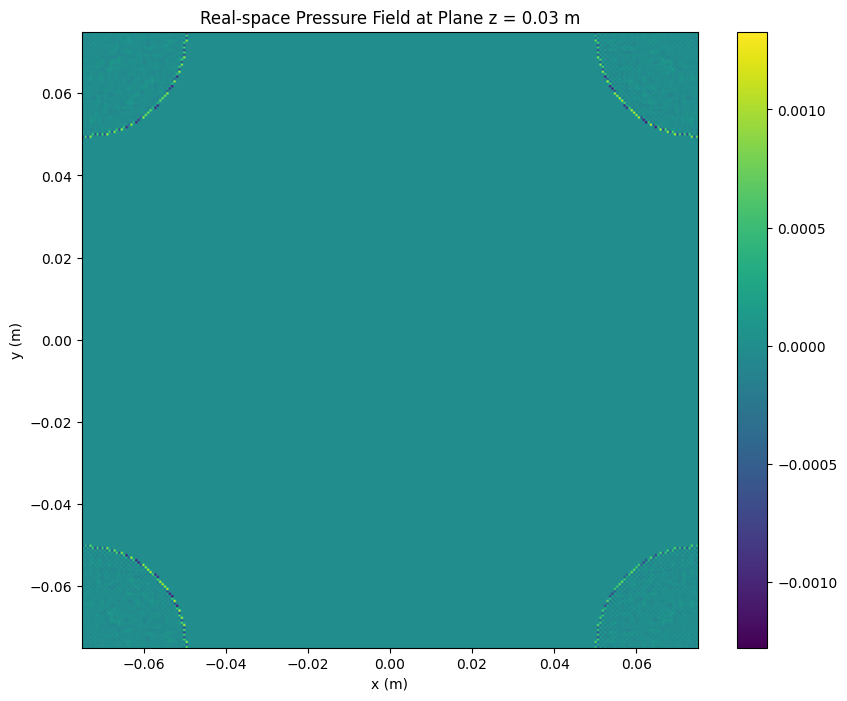

In [ ]:
#Pressure Field Visualization

# Propagate the calculated angular spectrum to the desired plane
desired_z = 0.03  # Change this to the desired z-plane
propagated_field_at_z = propagate(angular_spectrum_holo, desired_z, k_limit)

# Calculate the real-space pressure field using the inverse Fourier transform
pressure_field_at_z = ifft2(propagated_field_at_z)

# Normalize the pressure field by the factor from the equation
pressure_field_at_z *= 1 / (4 * np.pi**2)

# Visualize the real part of the pressure field
plt.figure(figsize=(10, 8))
plt.imshow(pressure_field_at_z.real, extent=(x.min(), x.max(), y.min(), y.max()))
plt.colorbar()
plt.title('Real-space Pressure Field at Plane z = {:.2f} m'.format(desired_z))
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

In [ ]:
alpha_T(x,y) = (4*Z_t*Z_h^2*Z_m)/(Z_h^2*(Z_t + Z_m)^2*cos(k_h*T(x,y))^2 + (Z_h^2 + Z_t*Z_m)^2*sin(k_h*T(x,y))^2)
delta_phi(x,y) = (k_m - k_h)*delta_T(x,y)